#**Non linear Schrodinger Equation using PINN's**
The Nonlinear Schrödinger Equation (NLSE) is generally solved in the form:

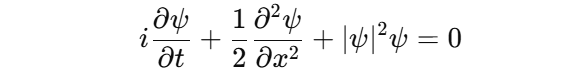<br>
For an initial wave packet solution, a common form of the solution could be a Gaussian wave packet or a soliton solution. A typical analytical solution in one spatial dimension for the nonlinear Schrödinger equation (in the form of solitons) can be expressed as:
</br>
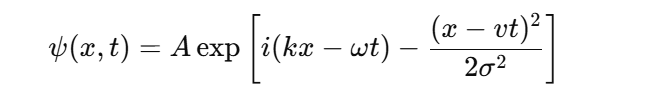

In [2]:
! pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=452dc3c126b59df2099eacb9ccfbc3feb31c8859b6950c0afd5db25f0dd8f543
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [3]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


## Function to find exact solution of Schrodinger's equation
The function returns an analytical solution to the NLSE based on a Gaussian wave packet.


In [4]:
def schrodinger_solution(A, k, w, v, sigma, x, t):
    """
    Analytical solution to the Nonlinear Schrödinger Equation (NLSE)
    in the form of a Gaussian wave packet.

    Args:
    A (float): Amplitude of the wave packet.
    k (float): Wave number.
    w (float): Frequency.
    v (float): Velocity of the wave packet.
    sigma (float): Width of the wave packet.
    x (torch.Tensor): Spatial coordinate(s).
    t (torch.Tensor): Time coordinate(s).

    Returns:
    torch.Tensor: The wave function ψ(x,t).
    """
    # Gaussian envelope with phase modulation
    exponent = -(x - v * t)**2 / (2 * sigma**2)  # Gaussian envelope
    phase = k * x - w * t  # Phase term
    psi = A * torch.exp(1j * phase) * torch.exp(exponent)

    return psi


## Generating Data and finding exact solution

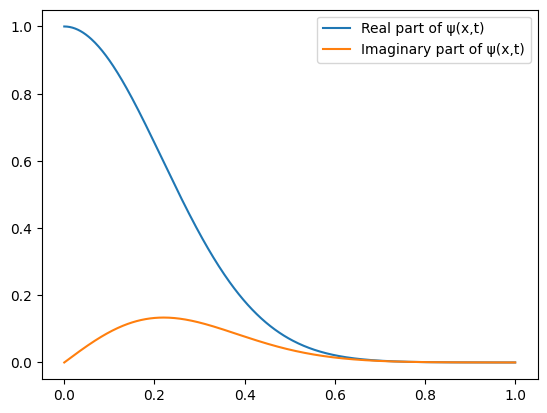

In [5]:
# Parameters for the initial Gaussian wave packet (soliton solution)
A = 1.0    # Amplitude
k = 2.0    # Wave number
w = 1.0    # Frequency
v = 0.1    # Velocity
sigma = 0.2 # Width of the wave packet

# Space and time coordinates
x = torch.linspace(0, 1, 500).view(-1, 1)  # Spatial grid
t = torch.linspace(0, 1, 500).view(-1, 1)  # Time grid

# Calculate the analytical solution for the wave function
psi = schrodinger_solution(A, k, w, v, sigma, x, t)

# Visualize the real and imaginary parts of the solution
plt.figure()
# Access real and imaginary parts using .real and .imag
plt.plot(x.numpy(), psi.real.detach().numpy(), label="Real part of ψ(x,t)")
plt.plot(x.numpy(), psi.imag.detach().numpy(), label="Imaginary part of ψ(x,t)")
plt.legend()
plt.show()

## Model Building

In [6]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn

class PINN_Schrodinger(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, activation=nn.ReLU()):
        super().__init__()
        self.activation = activation  # Set the activation function

        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            self.activation
        )

        self.fch = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                self.activation
            ) for _ in range(N_LAYERS - 1)
        ])

        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        outputs = self.fcs(inputs)
        outputs = self.fch(outputs)
        psi = self.fce(outputs)
        return psi


In [7]:
def loss_fn(model, x_data, t_data, psi_data, x_physics, t_physics ,launda ):
    """Calculate the combined loss: data loss + physics loss for NLSE"""

    # Data loss: Mean squared error between network prediction and known solution
    psi_pred = model(x_data, t_data)
    data_loss = torch.mean(torch.abs(psi_pred - psi_data)**2)

    # Physics loss: Ensure that the network satisfies the Nonlinear Schrödinger equation
    psi_physics = model(x_physics, t_physics)

    # Compute the partial derivatives of psi with respect to x and t
    psi_x = torch.autograd.grad(psi_physics, x_physics, torch.ones_like(psi_physics), create_graph=True)[0]
    psi_xx = torch.autograd.grad(psi_x, x_physics, torch.ones_like(psi_x), create_graph=True)[0]
    psi_t = torch.autograd.grad(psi_physics, t_physics, torch.ones_like(psi_physics), create_graph=True)[0]

    # Compute the residual of the NLSE: i∂ψ/∂t + 1/2 ∂²ψ/∂x² + |ψ|²ψ = 0
    physics_loss = torch.mean(torch.abs(1j * psi_t + 0.5 * psi_xx + torch.abs(psi_physics)**2 * psi_physics)**2)

    # Combine data and physics loss
    total_loss = data_loss + launda*physics_loss
    return total_loss


In [8]:

# Define spatial and temporal domain
x = torch.linspace(0, 1, 500).view(-1, 1)  # Space
t = torch.linspace(0, 1, 500).view(-1, 1)  # Time

# Define initial conditions for psi(x, t) (we use the Gaussian wave packet as the true solution)
A = 1.0
k = 2.0
w = 1.0
v = 0.1
sigma = 0.2
psi_exact = schrodinger_solution(A, k, w, v, sigma, x, t)

# Sample data (initial condition data)
x_data = x[:200]
t_data = t[:200]
psi_data = psi_exact[:200]  # Known solution at initial time

# Define physics points for enforcing the NLSE
x_physics = torch.linspace(0, 1, 50).view(-1, 1).requires_grad_(True)
t_physics = torch.linspace(0, 1, 50).view(-1, 1).requires_grad_(True)


In [9]:
def train_model(model, optimizer, scheduler, loss_fn, x_data, t_data, psi_data, x_physics, t_physics, launda,
                x, psi_exact, num_epochs=10000, plot_interval=2000):
    losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, x_data, t_data, psi_data, x_physics, t_physics, launda)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)  # Update the learning rate
        losses.append(loss.item())  # Store loss for plotting

        if (epoch + 1) % plot_interval == 0:
            with torch.no_grad():
                t_plot = t_data[0].repeat(x.shape[0], 1) # Replicate the first time point
                psi_pred = model(x, t_plot)
                psi_pred_real = psi_pred[:, 0]
                psi_pred_imag = psi_pred[:, 1]

                plt.figure(figsize=(8, 4))

                # Plot Real Part
                plt.subplot(1, 2, 1)
                plt.plot(x.numpy(), psi_exact.real.detach().numpy(), label="Actual (Real part)")
                plt.plot(x.numpy(), psi_pred_real.numpy(), label="Predicted (Real part)")
                plt.legend()
                plt.title(f"Real Part - Epoch {epoch+1}")

                # Plot Imaginary Part
                plt.subplot(1, 2, 2)
                plt.plot(x.numpy(), psi_exact.imag.detach().numpy(), label="Actual (Imaginary part)")
                plt.plot(x.numpy(), psi_pred_imag.numpy(), label="Predicted (Imaginary part)")
                plt.legend()
                plt.title(f"Imaginary Part - Epoch {epoch+1}")

                plt.tight_layout()
                plt.show()

    return losses

In [10]:
import matplotlib.pyplot as plt

def plot_training_loss(losses):
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()


## **Using ReLU Activation**

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


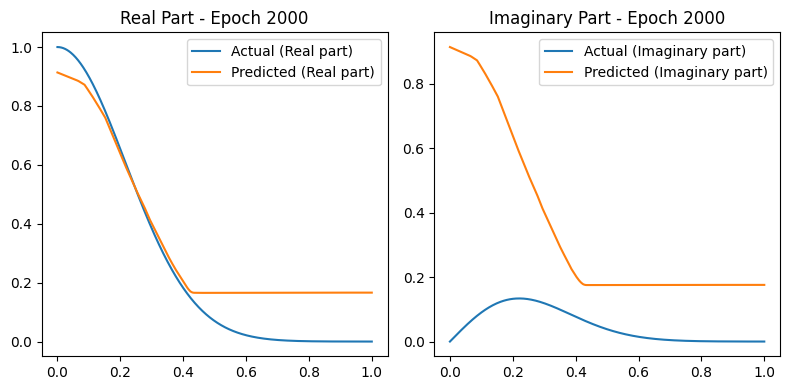

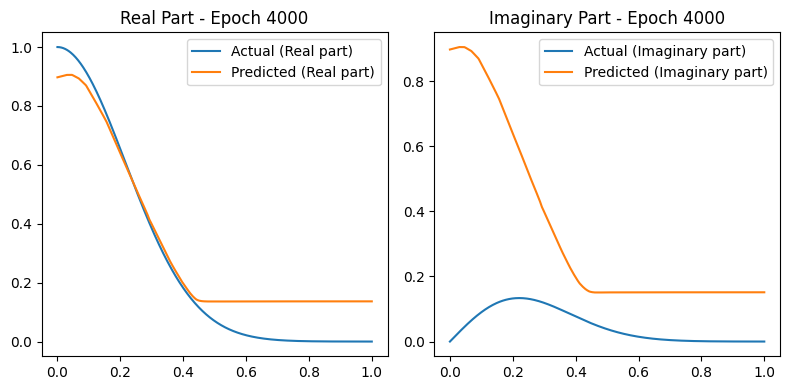

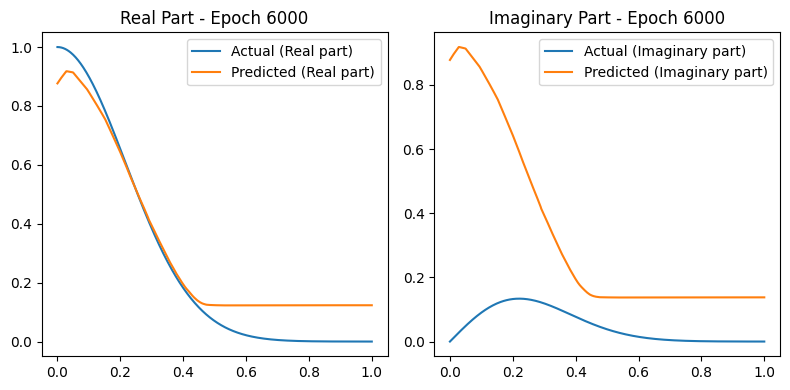

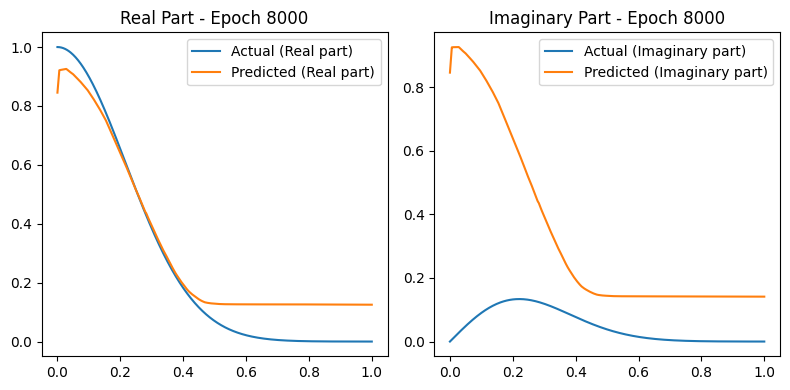

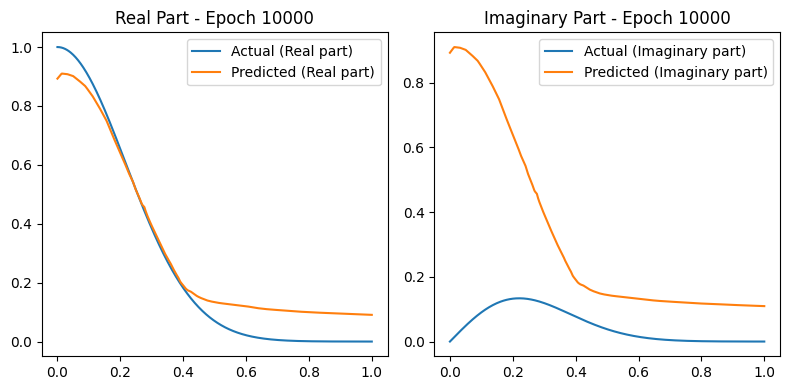

In [10]:
# Initialize the PINN model

# Training loop with improved learning rate scheduling and loss visualization
model = PINN_Schrodinger(2, 2, 64, 16 ,activation=nn.ReLU())  # Initialize the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # Increased initial learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=500, factor=0.5, verbose=True) # Learning rate scheduler


losses = [] # List to store losses
launda =1e-1


losses = train_model(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    x_data=x_data,
    t_data=t_data,
    psi_data=psi_data,
    x_physics=x_physics,
    t_physics=t_physics,
    launda=launda,
    x=x,
    psi_exact=psi_exact,
    num_epochs=10000,
    plot_interval=2000
)






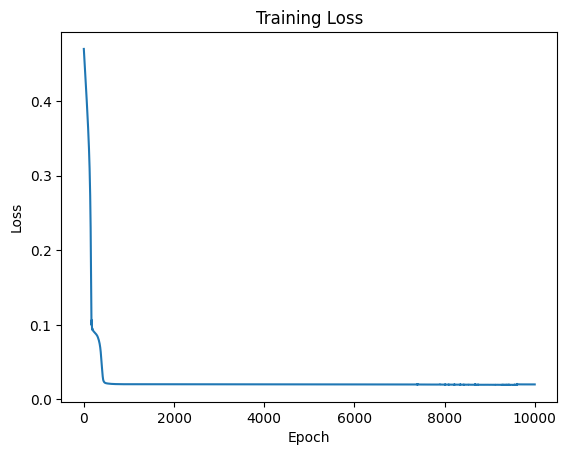

In [11]:
plot_training_loss(losses)


## **Using Gaussian Activation**

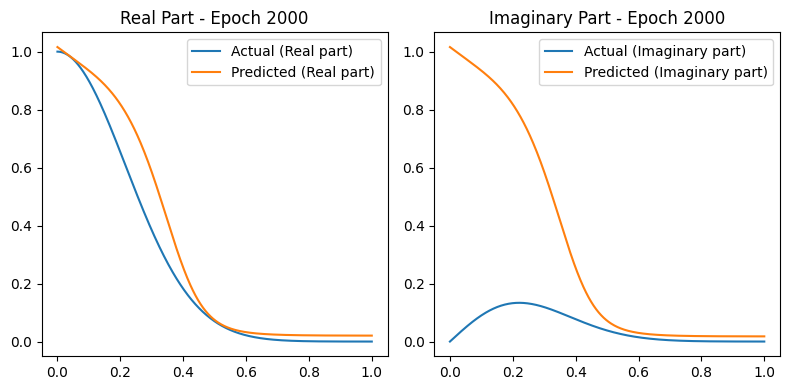

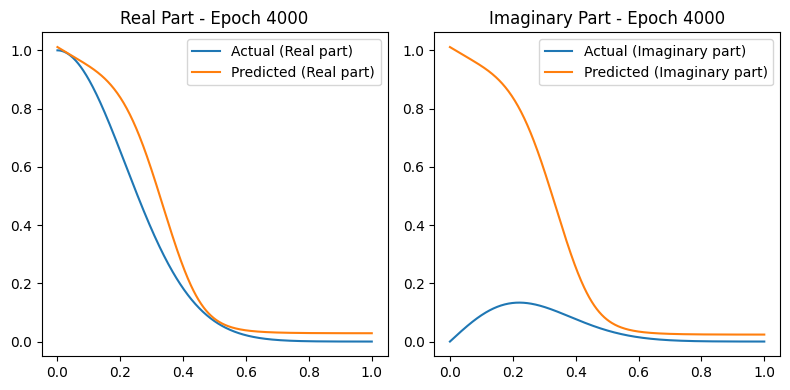

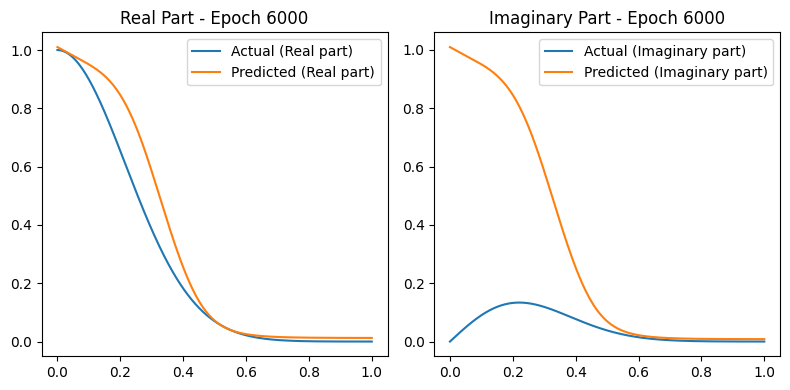

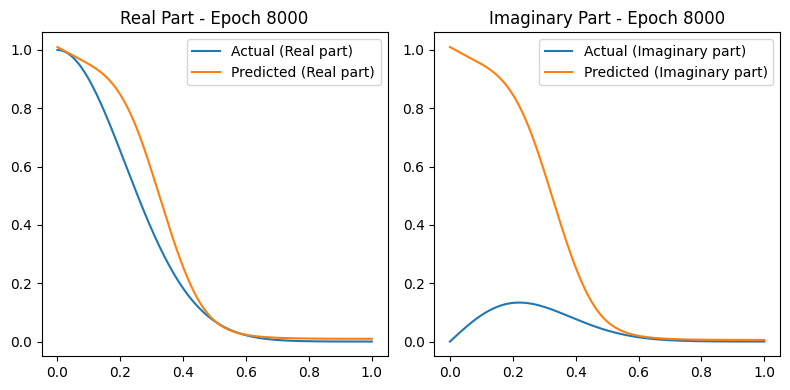

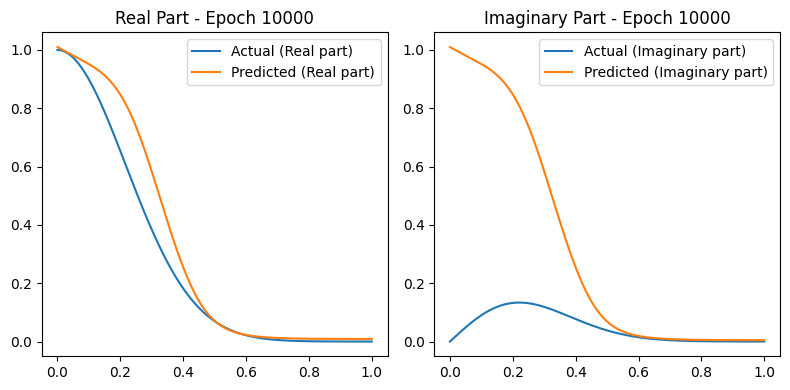

In [51]:
from pyDOE import lhs  # Latin Hypercube Sampling

class GaussianActivation(nn.Module):
    def forward(self, x):
        return torch.exp(-x ** 2)


# Initialize the PINN model
launda = 1e-3

# Training loop with improved learning rate scheduling and loss visualization
model = PINN_Schrodinger(2, 2, 64, 10 ,activation =GaussianActivation())  # Initialize the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Increased initial learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=500, factor=0.5, verbose=True) # Learning rate scheduler

losses = [] # List to store losses

losses = train_model(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    x_data=x_data,
    t_data=t_data,
    psi_data=psi_data,
    x_physics=x_physics,
    t_physics=t_physics,
    launda=launda,
    x=x,
    psi_exact=psi_exact,
    num_epochs=10000,
    plot_interval=2000
)


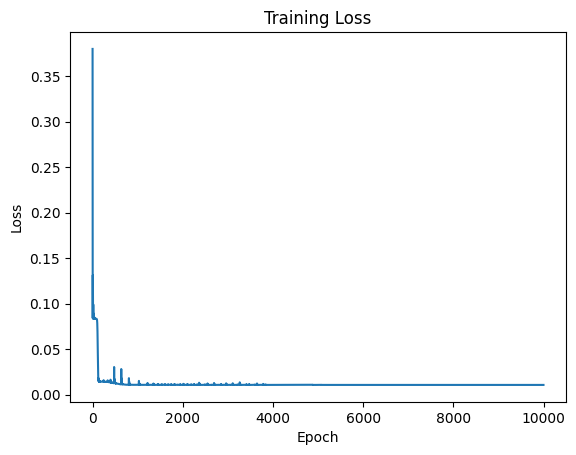

In [49]:
plot_training_loss(losses)


##**Using Swish Activation**

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


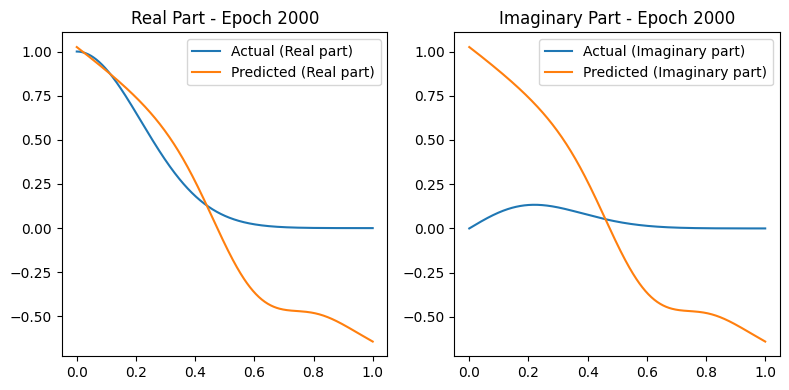

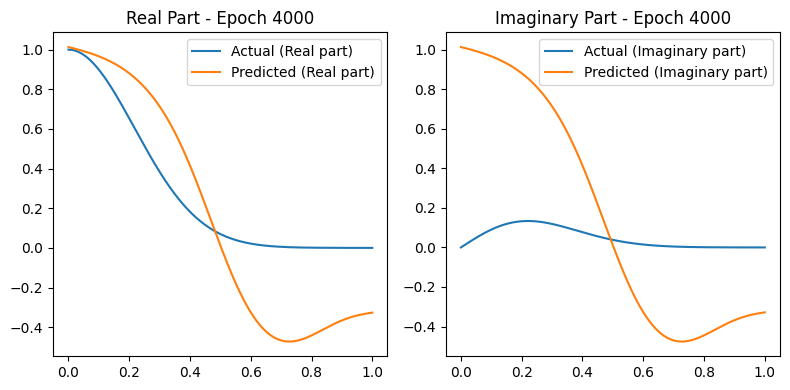

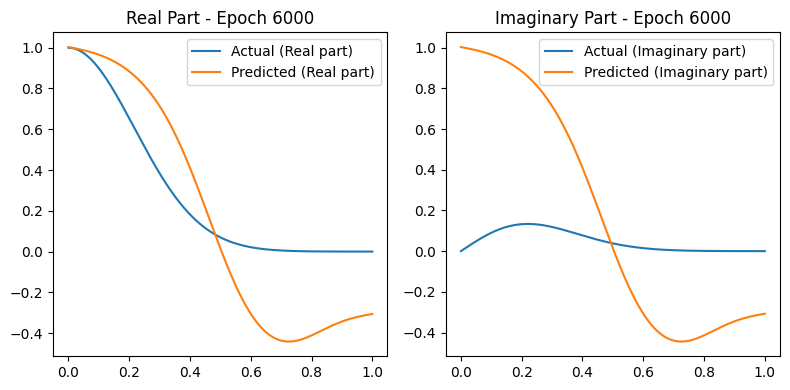

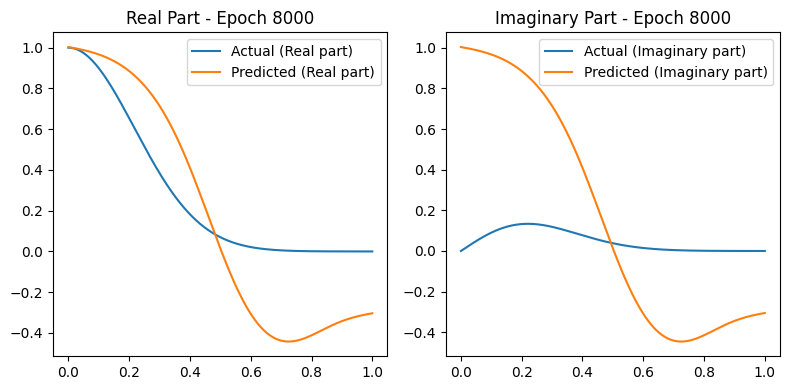

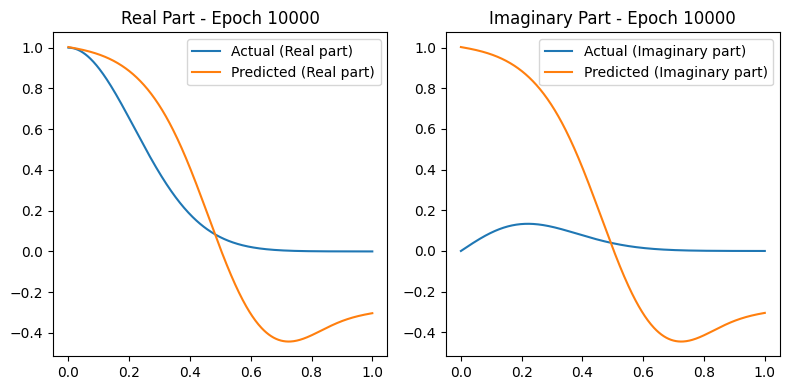

In [16]:

import torch.optim as optim
# Define the Swish activation function
class SwishActivation(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Initialize the model and training loop
model = PINN_Schrodinger(2, 2, 64,  10, activation = SwishActivation())
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=500, factor=0.5, verbose=True)

losses = []  # List to store losses
launda = 1e-3

# Training loop
losses = train_model(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    x_data=x_data,
    t_data=t_data,
    psi_data=psi_data,
    x_physics=x_physics,
    t_physics=t_physics,
    launda=launda,
    x=x,
    psi_exact=psi_exact,
    num_epochs=10000,
    plot_interval=2000
)


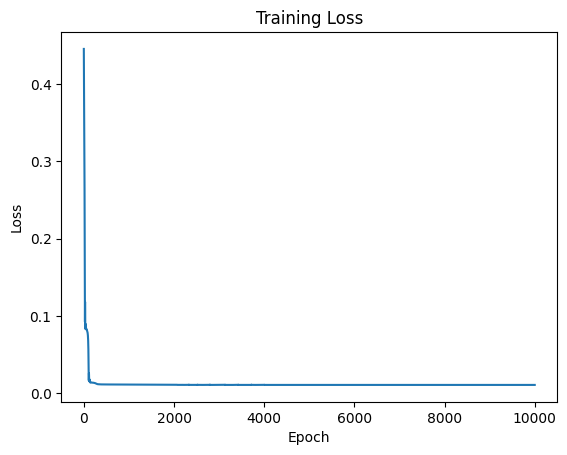

In [17]:
# Plot
plot_training_loss(losses)

##**Using Tanh Activation**

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


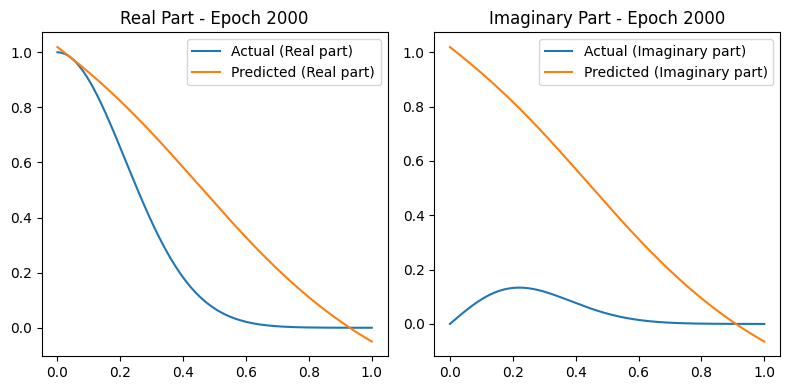

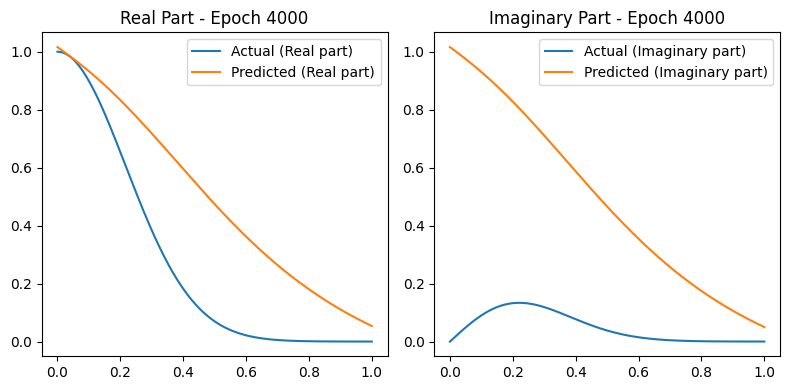

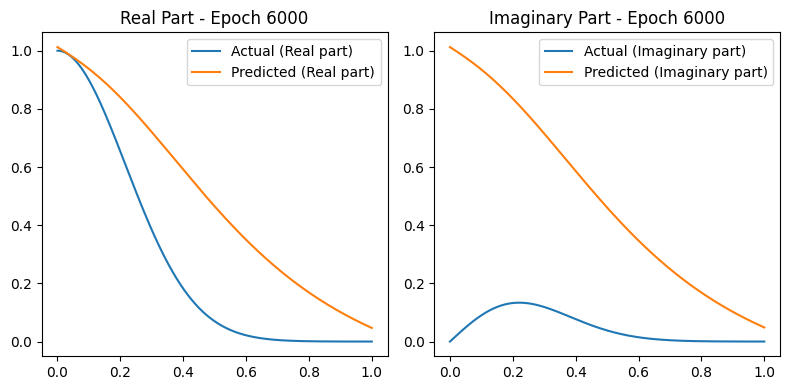

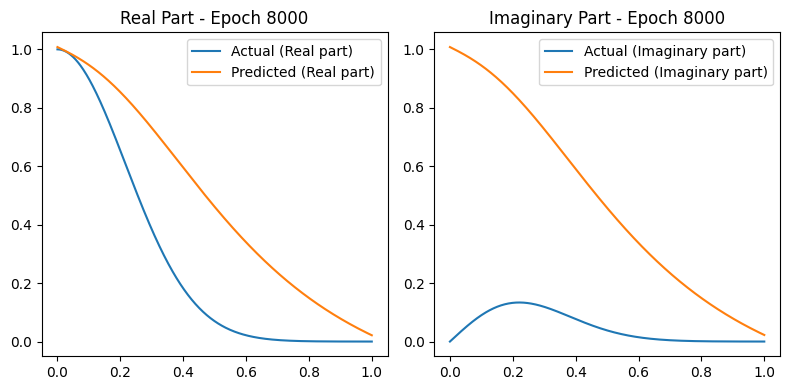

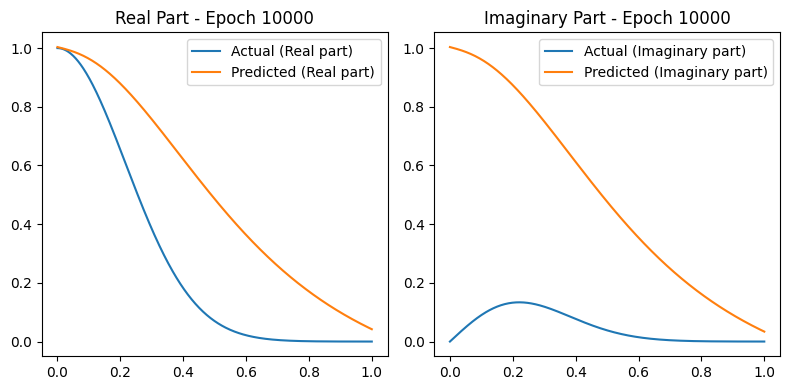

In [11]:

import torch.optim as optim
# Define the Swish activation function
class SwishActivation(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Initialize the model and training loop
model = PINN_Schrodinger(2, 2, 64,  10, activation = nn.Tanh())
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=500, factor=0.5, verbose=True)

losses = []  # List to store losses
launda = 1e-3

# Training loop
losses = train_model(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    x_data=x_data,
    t_data=t_data,
    psi_data=psi_data,
    x_physics=x_physics,
    t_physics=t_physics,
    launda=launda,
    x=x,
    psi_exact=psi_exact,
    num_epochs=10000,
    plot_interval=2000
)


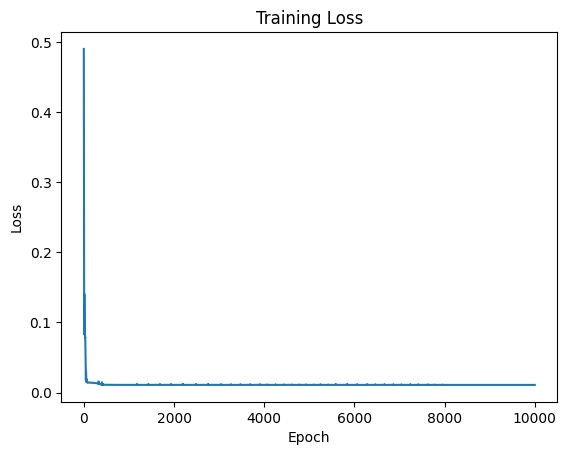

In [12]:
# Plot
plot_training_loss(losses)